### Logistic regression on Streptococcus agalactie

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import StratifiedGroupKFold, KFold

In [2]:
sa = pd.read_csv('/Users/alexandra/Desktop/thesis_programming/final_SA.csv')

/var/folders/mx/knhr23fd09g19g__8gz1fgxh0000gn/T/ipykernel_65889/1538803325.py:1: DtypeWarning: Columns (66485) have mixed types. Specify dtype option on import or set low_memory=False.
  sa = pd.read_csv('/Users/alexandra/Desktop/thesis_programming/final_SA.csv')


In [3]:
sa.shape

(409, 66486)

In [5]:
snp_columns = sa.filter(like='SNP')
snp_columns.shape


(409, 60103)

In [3]:
# Separate feature columns and target labels
X_noST = sa.drop(columns=['AMG',"TET","BAC","sample_ID", 'ST'], errors='ignore')

# Create individual datasets per antibiotic
# Split into features and labels
sa_amg = X_noST.copy()
sa_amg['label'] = sa['AMG']
y_noST_amg = sa_amg['label']

sa_tet = X_noST.copy()
sa_tet['label'] = sa['TET']
y_noST_tet = sa_tet['label']

sa_bac = X_noST.copy()
sa_bac['label'] = sa['BAC']
y_noST_bac = sa_bac['label']

### Classes visualization

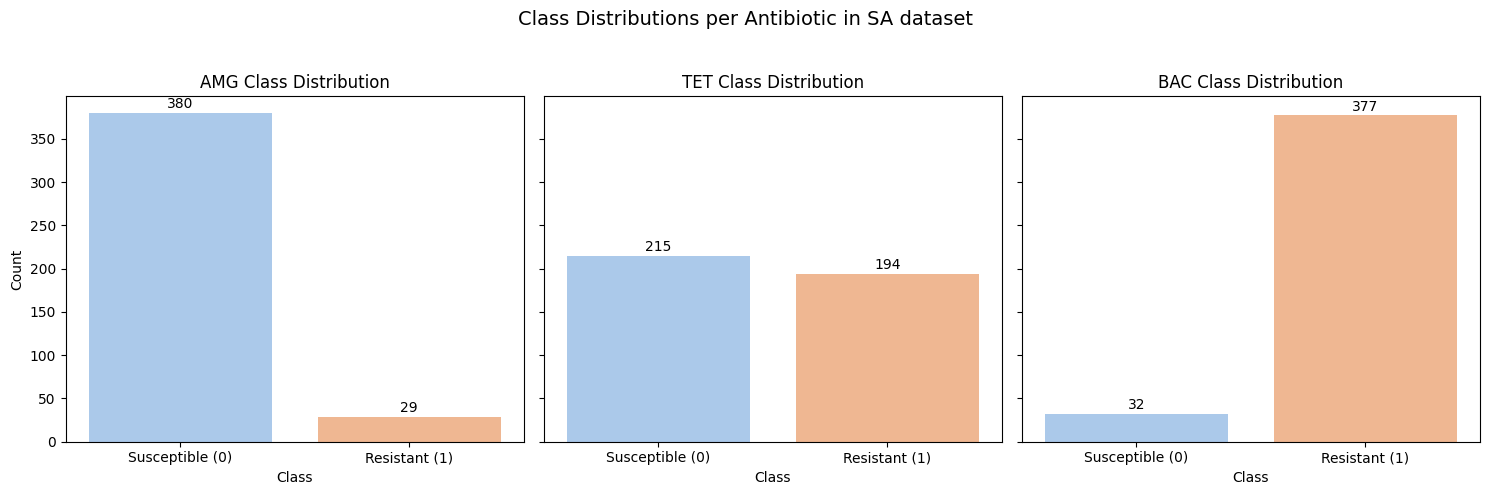

In [4]:
# Store your labels in a dictionary
labels_dict = {
    'AMG': y_noST_amg,
    'TET': y_noST_tet,
    'BAC': y_noST_bac
}

# Set up subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Plot each antibiotic
for ax, (name, y) in zip(axes, labels_dict.items()):
    sns.countplot(x=y, palette='pastel', ax=ax, hue=y)
    ax.set_title(f"{name} Class Distribution", fontsize=12)
    ax.set_xlabel("Class")
    ax.set_ylabel("Count" if name == 'AMG' else "")  # Only show y-axis on first
    ax.set_xticks([0, 1], ['Susceptible (0)', 'Resistant (1)'])
    ax.get_legend().remove()

    # Annotate counts
    for p in ax.patches:
        count = int(p.get_height())
        if count > 0:
            ax.annotate(f'{count}', (p.get_x() + p.get_width() / 2., count + 2),
                        ha='center', va='bottom', fontsize=10)


# Overall plot formatting
plt.suptitle("Class Distributions per Antibiotic in SA dataset", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()


### Blocked cross-validation

In [5]:
# Creating dictionary of parameters to tune
hparam = {"C":[0.001, 0.01, 0.1, 1.00]}

# Drop label columns
features = sa.drop(columns=["AMG", "TET", "BAC", "sample_ID"], errors='ignore')

# drop rows with no numeric ST values
features['ST'] = pd.to_numeric(features['ST'], errors='coerce')  
features_clean_ST = features.dropna(subset=['ST'])

In [6]:
# Creating function to perform hyper parameter tuning of model
def LG_hp_tune(param, feat_train_df, lab_train, v=3, cv=4):
  #creating logistic regression model
  model = LogisticRegression(random_state = 42, max_iter=1000, class_weight='balanced')

  # isolating the features used for training
  feat = feat_train_df.drop(columns=["ST"])
  
  # Grouped cross-validation
  groups = feat_train_df['ST']
  cv = StratifiedGroupKFold(n_splits=4)
  gs = GridSearchCV(model, param, scoring='f1_macro',cv=cv, refit='f1_macro', verbose=v, return_train_score=True)
  gs.fit(feat, lab_train, groups=groups)

  print(gs.best_params_)
  print(gs.best_score_)
  return gs.best_estimator_

##### 1. AMG

In [39]:
# Align labels with the cleaned features
labels_amg = sa.loc[features_clean_ST.index, 'AMG'] 

features_clean_ST['label'] = labels_amg

# Define X and y properly
X_amg = features_clean_ST.drop(columns=['label'])
y_amg = features_clean_ST['label']

# Split the data
X_train_amg, X_test_amg, y_train_amg, y_test_amg = train_test_split(
    X_amg, y_amg, stratify=y_amg, test_size=0.3, random_state=42)

# smote
smote_amg = SMOTE(random_state=42)
# Resample the training data
X_train_resampled_amg_clean_ST, y_train_resampled_amg_clean_ST = smote_amg.fit_resample(X_train_amg, y_train_amg)


/var/folders/mx/knhr23fd09g19g__8gz1fgxh0000gn/T/ipykernel_1724/1555537309.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_clean_ST['label'] = labels_amg


In [76]:
LG_tuned_amg = LG_hp_tune(hparam, X_train_resampled_amg_clean_ST, y_train_resampled_amg_clean_ST)
bestC_amg = LG_tuned_amg.get_params()['C']

Fitting 4 folds for each of 4 candidates, totalling 16 fits
[CV 1/4] END ....C=0.001; f1_macro: (train=0.986, test=0.815) total time=   4.0s
[CV 2/4] END ....C=0.001; f1_macro: (train=0.969, test=0.823) total time=   4.2s
[CV 3/4] END ....C=0.001; f1_macro: (train=0.976, test=0.926) total time=   3.2s
[CV 4/4] END ....C=0.001; f1_macro: (train=0.982, test=1.000) total time=   3.3s
[CV 1/4] END .....C=0.01; f1_macro: (train=1.000, test=0.834) total time=   2.2s
[CV 2/4] END .....C=0.01; f1_macro: (train=1.000, test=0.865) total time=   4.1s
[CV 3/4] END .....C=0.01; f1_macro: (train=1.000, test=1.000) total time=   4.2s
[CV 4/4] END .....C=0.01; f1_macro: (train=0.993, test=1.000) total time=   2.2s
[CV 1/4] END ......C=0.1; f1_macro: (train=1.000, test=0.797) total time=   3.2s
[CV 2/4] END ......C=0.1; f1_macro: (train=1.000, test=0.865) total time=   3.1s
[CV 3/4] END ......C=0.1; f1_macro: (train=1.000, test=1.000) total time=   4.2s
[CV 4/4] END ......C=0.1; f1_macro: (train=1.000,

##### 2. TET

In [66]:
# Align labels with the cleaned features
labels_tet = sa.loc[features_clean_ST.index, 'TET'] 

features_clean_ST['label'] = labels_tet

# Define X and y properly
X_tet = features_clean_ST.drop(columns=['label'])
y_tet = features_clean_ST['label']

# Split the data
X_train_tet_clean_ST, X_test_tet_clean_ST, y_train_tet_clean_ST, y_test_tet_clean_ST = train_test_split(
    X_tet, y_tet, stratify=y_tet, test_size=0.3, random_state=42)

In [82]:
LG_tuned_tet = LG_hp_tune(hparam, X_train_tet_clean_ST, y_train_tet_clean_ST)
bestC_tet = LG_tuned_tet.get_params()['C']

Fitting 4 folds for each of 4 candidates, totalling 16 fits
[CV 1/4] END ....C=0.001; f1_macro: (train=0.970, test=0.837) total time=   1.8s
[CV 2/4] END ....C=0.001; f1_macro: (train=0.929, test=0.894) total time=   1.1s
[CV 3/4] END ....C=0.001; f1_macro: (train=0.958, test=0.875) total time=   1.6s
[CV 4/4] END ....C=0.001; f1_macro: (train=0.935, test=0.855) total time=   1.7s
[CV 1/4] END .....C=0.01; f1_macro: (train=0.988, test=0.837) total time=   2.1s
[CV 2/4] END .....C=0.01; f1_macro: (train=1.000, test=0.964) total time=   2.0s
[CV 3/4] END .....C=0.01; f1_macro: (train=1.000, test=0.911) total time=   1.1s
[CV 4/4] END .....C=0.01; f1_macro: (train=0.994, test=0.891) total time=   1.1s
[CV 1/4] END ......C=0.1; f1_macro: (train=1.000, test=0.856) total time=   1.7s
[CV 2/4] END ......C=0.1; f1_macro: (train=1.000, test=0.964) total time=   1.7s
[CV 3/4] END ......C=0.1; f1_macro: (train=1.000, test=0.929) total time=   1.7s
[CV 4/4] END ......C=0.1; f1_macro: (train=1.000,

##### 3. BAC

In [71]:
# Align labels with the cleaned features
labels_bac = sa.loc[features_clean_ST.index, 'BAC'] 

features_clean_ST['label'] = labels_bac

# Define X and y properly
X_bac = features_clean_ST.drop(columns=['label'])
y_bac = features_clean_ST['label']

# Split the data
X_train_bac, X_test_bac, y_train_bac, y_test_bac = train_test_split(
    X_bac, y_bac, stratify=y_bac, test_size=0.3, random_state=42)

# smote
smote = SMOTE(random_state=42, sampling_strategy='not majority', k_neighbors=3)
X_train_resampled_bac_clean_ST, y_train_resampled_bac_clean_ST = smote.fit_resample(X_train_bac, y_train_bac)


/var/folders/mx/knhr23fd09g19g__8gz1fgxh0000gn/T/ipykernel_1724/2510614944.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_clean_ST['label'] = labels_bac


In [83]:
LG_tuned_bac = LG_hp_tune(hparam, X_train_resampled_bac_clean_ST, y_train_resampled_bac_clean_ST)
bestC_bac = LG_tuned_bac.get_params()['C']

Fitting 4 folds for each of 4 candidates, totalling 16 fits
[CV 1/4] END ....C=0.001; f1_macro: (train=0.987, test=0.791) total time=   4.3s
[CV 2/4] END ....C=0.001; f1_macro: (train=0.993, test=0.491) total time=   3.2s
[CV 3/4] END ....C=0.001; f1_macro: (train=0.984, test=1.000) total time=   2.4s
[CV 4/4] END ....C=0.001; f1_macro: (train=0.983, test=1.000) total time=   4.1s
[CV 1/4] END .....C=0.01; f1_macro: (train=0.997, test=0.870) total time=   4.3s
[CV 2/4] END .....C=0.01; f1_macro: (train=0.997, test=0.491) total time=   2.3s
[CV 3/4] END .....C=0.01; f1_macro: (train=0.993, test=1.000) total time=   3.4s
[CV 4/4] END .....C=0.01; f1_macro: (train=0.993, test=1.000) total time=   4.3s
[CV 1/4] END ......C=0.1; f1_macro: (train=1.000, test=0.870) total time=   3.2s
[CV 2/4] END ......C=0.1; f1_macro: (train=0.997, test=0.498) total time=   3.1s
[CV 3/4] END ......C=0.1; f1_macro: (train=0.997, test=1.000) total time=   2.1s
[CV 4/4] END ......C=0.1; f1_macro: (train=0.997,

### Training with best C and testing

In [5]:
# Train-test split
X_train_amg, X_test_amg, y_train_amg, y_test_amg = train_test_split(
    X_noST, y_noST_amg, stratify= y_noST_amg, test_size=0.3, random_state=42)

X_train_tet, X_test_tet, y_train_tet, y_test_tet = train_test_split(
    X_noST, y_noST_tet, stratify= y_noST_tet, test_size=0.3, random_state=42)

X_train_bac, X_test_bac, y_train_bac, y_test_bac = train_test_split(
    X_noST, y_noST_bac, stratify= y_noST_bac, test_size=0.3, random_state=42)

# Apply SMOTE
smote_amg = SMOTE(random_state=42)
smote_bac = SMOTE(random_state=42, sampling_strategy='not majority')
X_train_resampled_amg, y_train_resampled_amg = smote_amg.fit_resample(X_train_amg, y_train_amg)
X_train_resampled_bac, y_train_resampled_bac = smote_bac.fit_resample(X_train_bac, y_train_bac) 

print("AMG Resampled Class Distribution:", Counter(y_train_resampled_amg))
print("TET Class Distribution:", Counter(y_train_tet))
print("BAC Resampled Class Distribution:", Counter(y_train_resampled_bac))


AMG Resampled Class Distribution: Counter({0: 266, 1: 266})
TET Class Distribution: Counter({0: 150, 1: 136})
BAC Resampled Class Distribution: Counter({1: 264, 0: 264})


##### 1. AMG

Accuracy on test set: 0.9756
Accuracy on training set: 0.9981
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       114
           1       0.88      0.78      0.82         9

    accuracy                           0.98       123
   macro avg       0.93      0.88      0.91       123
weighted avg       0.97      0.98      0.97       123



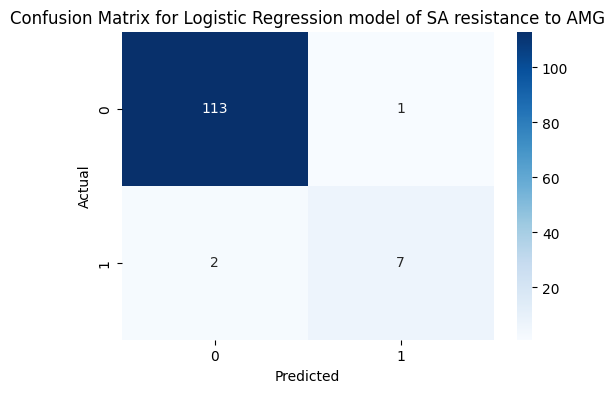

ROC-AUC on test set: 0.996


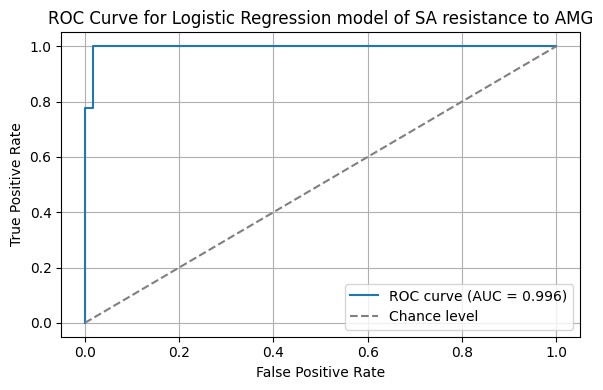

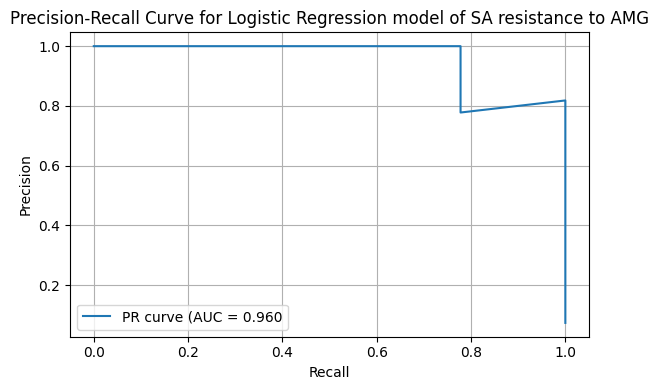

In [ ]:
model_amg = LogisticRegression(max_iter=500, class_weight='balanced', random_state=42, C=bestC_amg)

# Train the model
model_amg.fit(X_train_resampled_amg, y_train_resampled_amg)

# Predictions
y_pred = model_amg.predict(X_test_amg)
y_train_pred = model_amg.predict(X_train_resampled_amg)

# Probabilities for ROC and PR curves
y_prob = model_amg.predict_proba(X_test_amg)[:, 1]  # Probability for the positive class

# Accuracy scores
print(f"Accuracy on test set: {accuracy_score(y_test_amg, y_pred):.4f}")
print(f"Accuracy on training set: {accuracy_score(y_train_resampled_amg, y_train_pred):.4f}")

# Classification report and confusion matrix
print(classification_report(y_test_amg, y_pred))
cm = confusion_matrix(y_test_amg, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix for Logistic Regression model of SA resistance to AMG")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC-AUC score
roc_auc = roc_auc_score(y_test_amg, y_prob)
print(f"ROC-AUC on test set: {roc_auc:.3f}")

# Plot ROC-AUC Curve 
fpr, tpr, _ = roc_curve(y_test_amg, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Chance level')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Logistic Regression model of SA resistance to AMG")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Precision-Recall Curve 
precision, recall, _ = precision_recall_curve(y_test_amg, y_prob)
pr_auc = average_precision_score(y_test_amg, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.3f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Logistic Regression model of SA resistance to AMG")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


##### 2. TET

Accuracy on test set: 0.9837
Accuracy on training set: 1.0000
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        65
           1       0.97      1.00      0.98        58

    accuracy                           0.98       123
   macro avg       0.98      0.98      0.98       123
weighted avg       0.98      0.98      0.98       123



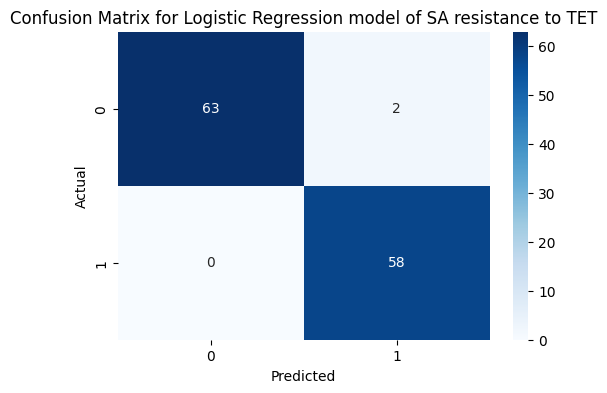

ROC-AUC on test set: 0.9939


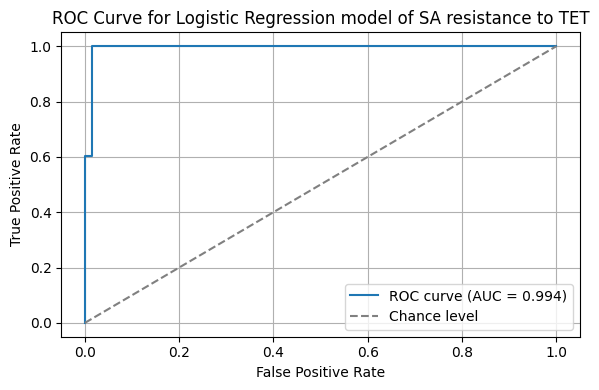

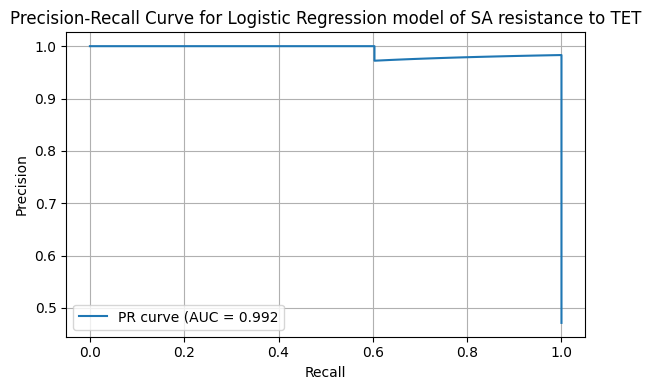

In [ ]:
model_tet = LogisticRegression(max_iter=500, class_weight='balanced', random_state=42, C=bestC_tet)

# Train the model
model_tet.fit(X_train_tet, y_train_tet)

# Predictions
y_pred = model_tet.predict(X_test_tet)
y_train_pred = model_tet.predict(X_train_tet)

# Probabilities for ROC and PR curves
y_prob = model_tet.predict_proba(X_test_tet)[:, 1]  # Probability for the positive class

# Accuracy scores
print(f"Accuracy on test set: {accuracy_score(y_test_tet, y_pred):.4f}")
print(f"Accuracy on training set: {accuracy_score(y_train_tet, y_train_pred):.4f}")

# Classification report and confusion matrix
print(classification_report(y_test_tet, y_pred))
cm = confusion_matrix(y_test_tet, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix for Logistic Regression model of SA resistance to TET")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC-AUC score
roc_auc = roc_auc_score(y_test_tet, y_prob)
print(f"ROC-AUC on test set: {roc_auc:.4f}")

# Plot ROC-AUC Curve 
fpr, tpr, _ = roc_curve(y_test_tet, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Chance level')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Logistic Regression model of SA resistance to TET")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Precision-Recall Curve 
precision, recall, _ = precision_recall_curve(y_test_tet, y_prob)
pr_auc = average_precision_score(y_test_tet, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.3f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Logistic Regression model of SA resistance to TET")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


##### 3. BAC

Accuracy on test set: 0.9919
Accuracy on training set: 1.0000
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       0.99      1.00      1.00       113

    accuracy                           0.99       123
   macro avg       1.00      0.95      0.97       123
weighted avg       0.99      0.99      0.99       123



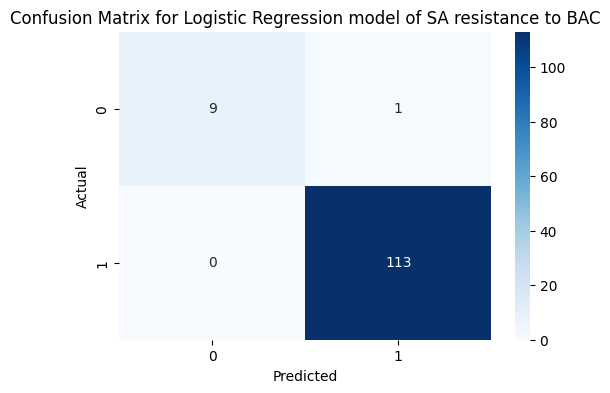

ROC-AUC on test set: 0.9504


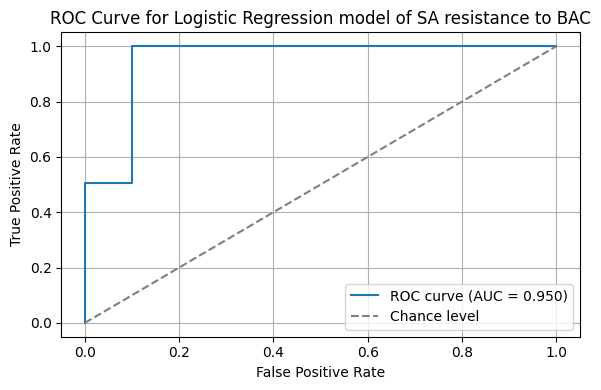

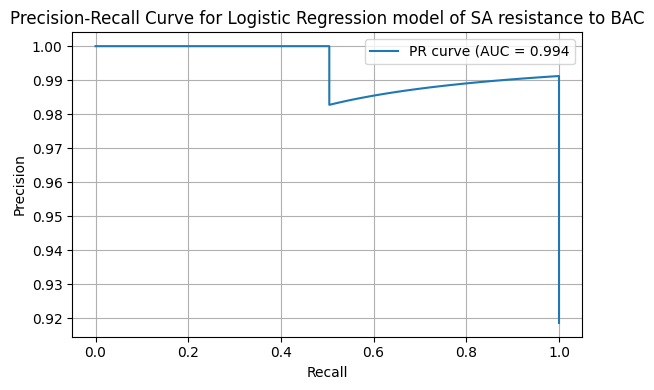

In [ ]:
model_bac = LogisticRegression(max_iter=500, class_weight='balanced', random_state=42, C=bestC_bac)

# Train the model
model_bac.fit(X_train_resampled_bac, y_train_resampled_bac)

# Predictions
y_pred = model_bac.predict(X_test_bac)
y_train_pred = model_bac.predict(X_train_resampled_bac)

# Probabilities for ROC and PR curves
y_prob = model_bac.predict_proba(X_test_bac)[:, 1]  # Probability for the positive class

# Accuracy scores
print(f"Accuracy on test set: {accuracy_score(y_test_bac, y_pred):.4f}")
print(f"Accuracy on training set: {accuracy_score(y_train_resampled_bac, y_train_pred):.4f}")

# Classification report and confusion matrix
print(classification_report(y_test_bac, y_pred))
cm = confusion_matrix(y_test_bac, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix for Logistic Regression model of SA resistance to BAC")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC-AUC score
roc_auc = roc_auc_score(y_test_bac, y_prob)
print(f"ROC-AUC on test set: {roc_auc:.4f}")

# Plot ROC-AUC Curve 
fpr, tpr, _ = roc_curve(y_test_bac, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Chance level')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Logistic Regression model of SA resistance to BAC")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Precision-Recall Curve 
precision, recall, _ = precision_recall_curve(y_test_bac, y_prob)
pr_auc = average_precision_score(y_test_bac, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.3f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Logistic Regression model of SA resistance to BAC")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Regression coefficients

##### 1. AMG

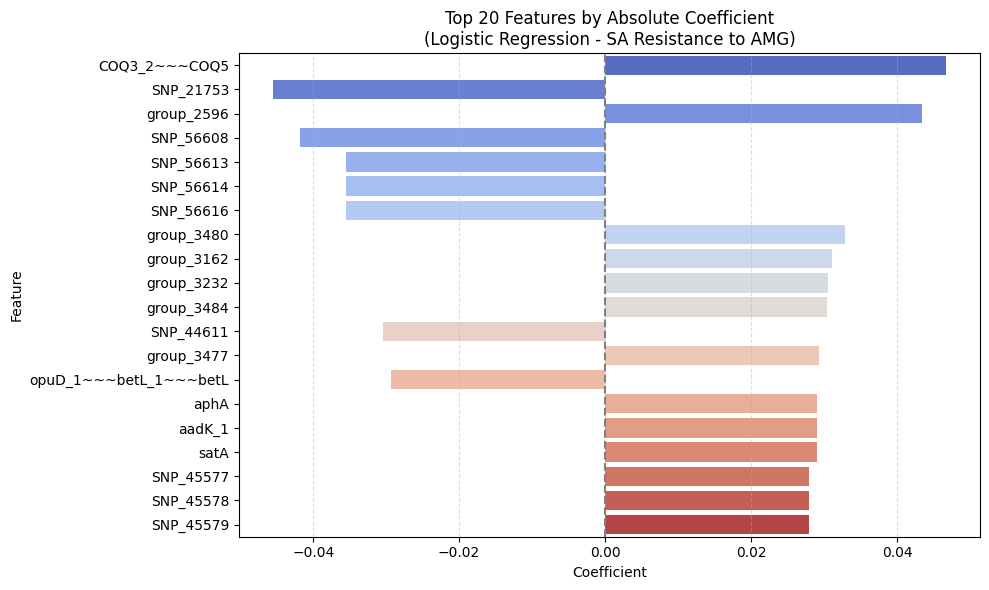

In [21]:
# Extract coefficients and feature names
coef = model_amg.coef_[0]
features = X_noST.columns

# Create DataFrame
coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': coef,
    'Odds Ratio': np.exp(coef),
    'Abs Coefficient': np.abs(coef)
})

# Sort by absolute coefficient value
coef_df_sorted = coef_df.sort_values(by='Abs Coefficient', ascending=False).head(20)

# Plot
plt.figure(figsize=(10, 6))
plt.grid(axis='x', linestyle='--', alpha=0.4)
sns.barplot(
    data=coef_df_sorted,
    y='Feature',
    x='Coefficient',
    palette='coolwarm',
    hue='Feature'
)
plt.axvline(0, color='gray', linestyle='--')

plt.title('Top 20 Features by Absolute Coefficient\n(Logistic Regression - SA Resistance to AMG)')
plt.tight_layout()
plt.show()


##### 2. TET

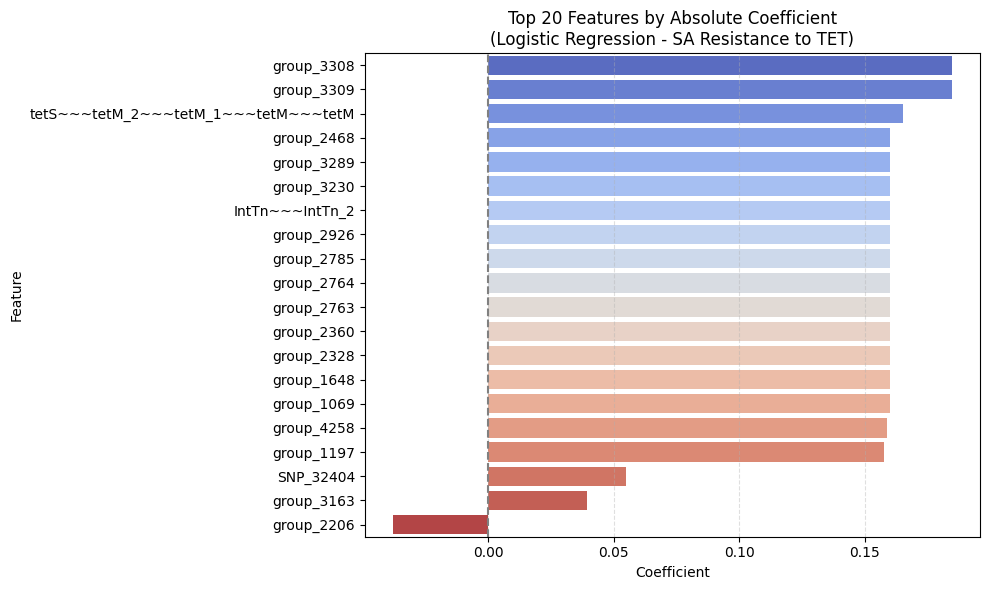

In [19]:
# Extract coefficients and feature names
coef = model_tet.coef_[0]
features = X_noST.columns

# Create DataFrame
coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': coef,
    'Odds Ratio': np.exp(coef),
    'Abs Coefficient': np.abs(coef)
})

# Sort by absolute coefficient value
coef_df_sorted = coef_df.sort_values(by='Abs Coefficient', ascending=False).head(20)

# Plot
plt.figure(figsize=(10, 6))
plt.grid(axis='x', linestyle='--', alpha=0.4)
sns.barplot(
    data=coef_df_sorted,
    y='Feature',
    x='Coefficient',
    palette='coolwarm',
    hue='Feature'
)
plt.axvline(0, color='gray', linestyle='--')

plt.title('Top 20 Features by Absolute Coefficient\n(Logistic Regression - SA Resistance to TET)')
plt.tight_layout()
plt.show()


##### 3. BAC

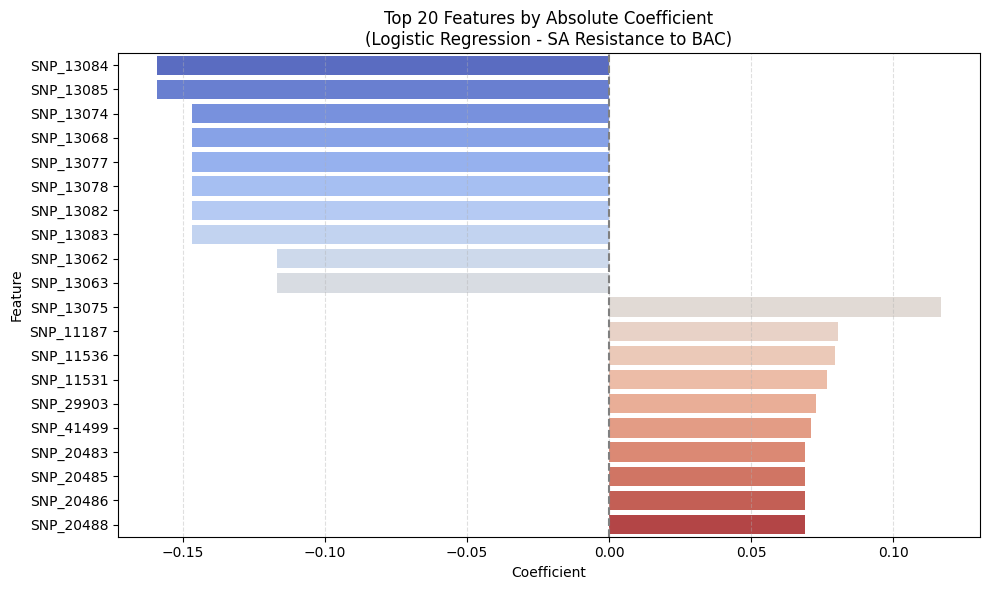

In [22]:
# Extract coefficients and feature names
coef = model_bac.coef_[0]
features = X_noST.columns

# Create DataFrame
coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': coef,
    'Odds Ratio': np.exp(coef),
    'Abs Coefficient': np.abs(coef)
})

# Sort by absolute coefficient value
coef_df_sorted = coef_df.sort_values(by='Abs Coefficient', ascending=False).head(20)

# Plot
plt.figure(figsize=(10, 6))
plt.grid(axis='x', linestyle='--', alpha=0.4)
sns.barplot(
    data=coef_df_sorted,
    y='Feature',
    x='Coefficient',
    palette='coolwarm',
    hue='Feature'
)
plt.axvline(0, color='gray', linestyle='--')

plt.title('Top 20 Features by Absolute Coefficient\n(Logistic Regression - SA Resistance to BAC)')
plt.tight_layout()
plt.show()
